# torchkeras.LightModel TensorBoard Demo

You can install torchkeras using pip:
`pip install torchkeras`

Here is a complete example using torchkeras.LightModel  with visualization of tensorboad.



In [1]:
import sys 
sys.path.append("..")

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

import torchkeras #Attention this line 


### 1, prepare data 

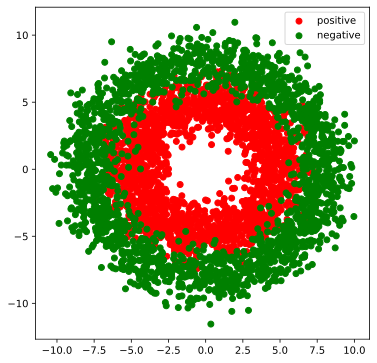

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#number of samples
n_positive,n_negative = 2000,2000

#positive samples
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#negative samples
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#concat positive and negative samples
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#visual samples
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


In [4]:
# split samples into train and valid data.
ds = TensorDataset(X,Y)
ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 200,shuffle=True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 200,num_workers=2)


In [5]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([200, 2])
torch.Size([200, 1])


### 2, create the  model

In [6]:
class Net(nn.Module):  
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x) #don't need nn.Sigmoid()
        return y
    
net = Net() 


In [7]:
from torchkeras.metrics import Accuracy 

loss_fn = nn.BCEWithLogitsLoss()
metric_dict = {"acc":Accuracy()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.03)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

model = torchkeras.LightModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer,
                   lr_scheduler = lr_scheduler,
                  )       

from torchkeras import summary
summary(model,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 4]                   12
Linear-2                                     [-1, 8]                   40
Linear-3                                     [-1, 1]                    9
Total params: 61
Trainable params: 61
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000401
--------------------------------------------------------------------------


/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(


### 3, train the model

In [8]:
import pytorch_lightning as pl  
from torchkeras.lightcallbacks import TensorBoardCallback

In [9]:
#1，设置回调函数
model_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min'
)

early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_loss',
                           patience=5,
                           mode = 'min'
                          )

tensorboard = TensorBoardCallback(
    save_dir='tb_logs',
    model_name='cnn',
    log_weight=True,
    log_weight_freq=2,
    log_graph=True,
    example_input_array=features,
    log_hparams=True,
    hparams_dict=None,
)


#2，设置训练参数
trainer = pl.Trainer(logger=True,
                     min_epochs=3,
                     max_epochs=20,
                     accelerator='mps', #mps/gpu/cpu
                     devices=1,
                     callbacks = [model_ckpt,early_stopping,tensorboard],
                     enable_progress_bar = True) 


#断点续训
#trainer = pl.Trainer(resume_from_checkpoint='./lightning_logs/version_31/checkpoints/epoch=02-val_loss=0.05.ckpt')

##4，启动训练循环
trainer.fit(model,dl_train,dl_val)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/liangyun2/CodeFiles/torchkeras/lightning_logs

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | Net               | 61    
1 | train_metrics | ModuleDict        | 0     
2 | val_metrics   | ModuleDict        | 0     
3 | test_metrics  | ModuleDict        | 0     
4 | loss_fn       | BCEWithLogitsLoss | 0     
----------------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



================================================================================2023-01-28 19:05:23
{'epoch': 0, 'val_loss': 0.710760235786438, 'val_acc': 0.4675000011920929}


<<<<<< reach best val_loss : 0.710760235786438 >>>>>>
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:24
{'epoch': 0, 'val_loss': 0.6386221051216125, 'val_acc': 0.659166693687439}
{'epoch': 0, 'train_loss': 0.6730556488037109, 'train_acc': 0.595714271068573}


<<<<<< reach best val_loss : 0.6386221051216125 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:25
{'epoch': 1, 'val_loss': 0.4686248302459717, 'val_acc': 0.8258333802223206}
{'epoch': 1, 'train_loss': 0.5712457895278931, 'train_acc': 0.7307142615318298}


<<<<<< reach best val_loss : 0.4686248302459717 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:27
{'epoch': 2, 'val_loss': 0.2891998291015625, 'val_acc': 0.8983333706855774}
{'epoch': 2, 'train_loss': 0.3671671748161316, 'train_acc': 0.8867856860160828}


<<<<<< reach best val_loss : 0.2891998291015625 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:28
{'epoch': 3, 'val_loss': 0.22951658070087433, 'val_acc': 0.9075000286102295}
{'epoch': 3, 'train_loss': 0.24857592582702637, 'train_acc': 0.9085714221000671}


<<<<<< reach best val_loss : 0.22951658070087433 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:29
{'epoch': 4, 'val_loss': 0.22103674709796906, 'val_acc': 0.9083333611488342}
{'epoch': 4, 'train_loss': 0.22562117874622345, 'train_acc': 0.9096428751945496}


<<<<<< reach best val_loss : 0.22103674709796906 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:30
{'epoch': 5, 'val_loss': 0.2444489598274231, 'val_acc': 0.8891667127609253}
{'epoch': 5, 'train_loss': 0.22071194648742676, 'train_acc': 0.9135714173316956}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:31
{'epoch': 6, 'val_loss': 0.22069518268108368, 'val_acc': 0.9025000333786011}
{'epoch': 6, 'train_loss': 0.21782073378562927, 'train_acc': 0.9182142615318298}


<<<<<< reach best val_loss : 0.22069518268108368 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:33
{'epoch': 7, 'val_loss': 0.21132688224315643, 'val_acc': 0.909166693687439}
{'epoch': 7, 'train_loss': 0.20950761437416077, 'train_acc': 0.9157142639160156}


<<<<<< reach best val_loss : 0.21132688224315643 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:34
{'epoch': 8, 'val_loss': 0.2219521403312683, 'val_acc': 0.9075000286102295}
{'epoch': 8, 'train_loss': 0.20894476771354675, 'train_acc': 0.9171428680419922}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:35
{'epoch': 9, 'val_loss': 0.21800990402698517, 'val_acc': 0.9050000309944153}
{'epoch': 9, 'train_loss': 0.20153985917568207, 'train_acc': 0.9200000166893005}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:36
{'epoch': 10, 'val_loss': 0.21797823905944824, 'val_acc': 0.9050000309944153}
{'epoch': 10, 'train_loss': 0.19976571202278137, 'train_acc': 0.9196428656578064}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:37
{'epoch': 11, 'val_loss': 0.21792133152484894, 'val_acc': 0.9050000309944153}
{'epoch': 11, 'train_loss': 0.19970865547657013, 'train_acc': 0.9192857146263123}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-28 19:05:38
{'epoch': 12, 'val_loss': 0.21785545349121094, 'val_acc': 0.9050000309944153}
{'epoch': 12, 'train_loss': 0.1996375173330307, 'train_acc': 0.9192857146263123}


### 4, Monitor from TensorBoard


TensorBoardCallback saves logs at the directory  'tb_logs'.

We can monitor and analysis training process using TensorBoard now.

!tensorboard --logdir="./tb_logs" --bind_all --port=6006

In [ ]:
from tensorboard import notebook
notebook.list() 
notebook.start("--logdir ./tb_logs")


#### metrics

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h412vlgpqdj20n40cmaaf.jpg)

#### graphs

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h4130c9g6lj20d90dd0st.jpg)

#### histograms 

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h4132au1scj20e709xjri.jpg) 